In [26]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lokeshwaran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lokeshwaran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lokeshwaran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
# fetch data from new_train.csv
data = pd.read_csv('new_train.csv', header = None)

In [28]:
text_data = data.iloc[:, 1]
print(text_data[0])

Eat at Fioris, they said.  Youll like it, they said.\n\nis it conveniently located on West Liberty Boulevard, this restaurant features absolutely nowhere to park on the road that is impossible to get to.\n\nWhen I called to place our order a miserable sounding me an answer the phone with the side and then said what do you need? I placed our order and he said don't come down here it's going to be at least an hour to we can get to you if my coworkers can do anything right. That was really unprofessional. Some people may think that character but really I don't care what kind of a day the person taking the pizza order is having I just want to place my order without feeling im bothering them,\n\nYou should know that you will have to illegally parked your car to pick your order up.  the place was filthy inside and it was packed full of people and total mayhem. I would never ever recommend eating in store even if the place was clean up you're still going to have people waiting to pick three o

# Text Preprocessing

In [29]:
def preprocess_text(text):
    text = text.lower() # lower the text
    words = word_tokenize(text) # tokenize the text
    words = [re.sub(r'[^\w\s]', '', word) for word in words] # Removing the punctuations
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words] # Eliminating stop words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words] # Lemmatization for the text
    lemmatized_words = [word for word in lemmatized_words if word != ""]
    return " ".join(lemmatized_words)

In [30]:
data[1] = data[1].apply(preprocess_text)

In [31]:
print(data[1][1])

nt understand appeal tried place twice thinking somehow lemon burger first time returned month later nope smoked flavor okay meat seems fresh hell flavor go far saying nt believe even season burger salt pepper closed eye possible would nt even know hamburger embarrassing maybe used eating 99 cent burger sysco meat chain restaurant would find amazing best burger many city u embarrassment pittsburgh go brgr want tasty burger near bloomfield end spectrum side side classic definitely average especially home fry would consider 1 star rating nt additionally place overly crowded long wait weekend decor old school seems satisfied current state like food file one legacy restaurant still living past accolade


# TF-IDF 

In [32]:
data = data[data[1].apply(lambda x: len(x) > 0)] # removing the missing data
count_vect = CountVectorizer()
X = count_vect.fit_transform(data[1]) # count vectorizer to count the frequency of words
tf_transformer = TfidfTransformer().fit(X)
X_train = tf_transformer.transform(X) # tf-idf calculation
Y_train = data[0].values

In [33]:
class KNN:
    def __init__(self, k):
        self.k = k #initializing k value
        
    def fit_data(self, X_train, Y_train):
        # fitting training and test data
        self.X_train = X_train
        self.Y_train = Y_train
        
    def euclidean_distance(self, x, y):
        # Euclidean distance calculation
        return np.sqrt(np.sum((x - y) ** 2))   
    
    def manhattan_distance(self, x, y):
        # Manhattan distance calculation
        return np.sum(np.abs(x - y))  
    def cosine_similarity(self, x, y):
        #cosine similarity calculation
        dot_product = np.dot(x, y)
        norm_x = np.linalg.norm(x)
        norm_y = np.linalg.norm(y)
        cosine_similarity = dot_product / (norm_x * norm_y)
        
        return cosine_similarity
        
    def predict_data(self, X):  
        y_prediction = [self.prediction(x) for x in X]
        return y_prediction
    
    def find_k_nearest_neighbors(self, distances):
        
        ''' ***** Finding K nearest labels ***
             1) Sorting the distances in descending order
             2) Getting first K indices
             3) Getting the labels of that indices'''
        
        sorted_distances = dict(sorted(distances.items(), key=lambda item: -item[1]))
        k_nearest_indices = list(sorted_distances.keys())[:self.k]
        k_nearest_labels = [self.Y_train[i] for i in k_nearest_indices]
        return k_nearest_labels
    
    def find_y_predicted(self, k_nearest_neighbors):
        
        ''' **** Predicting the class based on K nearest neighbors **** 
        
             1) Calculating each labels count 
             2) Find the label with max count '''
        
        target_class = {1: 0, -1: 0}
        for label in k_nearest_neighbors:
            target_class[label]+=1
            
        y_pred = max(target_class, key = target_class.get)
        return y_pred
    
    def prediction(self, x):
        
        ''' **** Pipeline for KNN **** 
             1) Finding the distances for each x_test values
             2) Find the K - nearest neighbors
             3) Predicting the Y label.  '''
        distances = {}
        for i in range(len(self.X_train)):
            # using cosine similarity because it gives best result..
            distance = self.cosine_similarity(x, self.X_train[i])
            distances[i] = distance
            
        k_nearest_labels = self.find_k_nearest_neighbors(distances)
        y_predicted = self.find_y_predicted(k_nearest_labels)
        
        return y_predicted
            
            

In [34]:
def cross_validation_calculation(predictions, Y_test):
    
    ''' *** Cross Validation Calculation [Confusion Matrix] *** 
          1) Finding TF, TN, FP and FN for calculating the accuracy score
    '''
    TP = TN = FP = FN = 0
    for true_label, predicted_label in zip(Y_test, predictions):
    # Calculate TP, TN, FP, FN
        if true_label == 1 and predicted_label == 1:
            TP += 1
        elif true_label == -1 and predicted_label == -1:
            TN += 1
        elif true_label == -1 and predicted_label == 1:
            FP += 1
        elif true_label == 1 and predicted_label == -1:
            FN += 1
    return [TP, TN, FP, FN]    
        

In [35]:
def k_fold_cross_validation(X, Y, folds, k):
    
    ''' *** K- fold selecting code *** '''
    
    #initailizing the folds
    x_train_folds = []
    x_test_folds = []
    
    y_train_folds = []
    y_test_folds = []
    summ = 0
    X, Y = shuffle(X, Y, random_state=42)
    fold_size = len(X) // folds # calculating the fold size
    for i in range(folds):
        #calculating the indexes
        start_index = i * fold_size
        end_index = (i+1) * fold_size if i < (folds - 1) else len(X)
        # fetch and update the values based on the index
        x_test_set = X[start_index:end_index]
        x_train_set = np.concatenate((X[:start_index], X[end_index:]))
        y_test_set = Y[start_index:end_index]
        y_train_set = np.concatenate((Y[:start_index], Y[end_index:]))
        X_train_fold, X_val_fold = x_train_set, x_test_set
        Y_train_fold, Y_val_fold = y_train_set, y_test_set
        knn_classifier = KNN(k=k)
        knn_classifier.fit_data(X_train_fold, Y_train_fold)
        predictions = knn_classifier.predict_data(X_val_fold)
        confusion_matrix = cross_validation_calculation(predictions, Y_val_fold)
        accuracy_score = (confusion_matrix[0] + confusion_matrix[1]) / (len(Y_val_fold))
        summ+=accuracy_score
        print("k: {} ====== fold index: {} ==== accuracy: {}".format(k, i, accuracy_score))

    print('Avg accuracy', summ/ folds) # calculating average accuracy
    return summ/folds

# Feature Reduction

In [36]:
k_best = SelectKBest(score_func=chi2, k=5000)  # assigning k = 3000 for selecting top 3000 features

X_new = k_best.fit_transform(X_train, Y_train) # fit and transform for X_train and Y_train
selected_feature_indices = k_best.get_support(indices=True)


In [37]:
X_train = X_train.toarray()
X_train = X_train[:,selected_feature_indices]

In [38]:
print(len(selected_feature_indices))

5000


# K-fold Cross Validation

In [ ]:
folds = 5
k1 = {}
for k in range(11,18):
    x = k_fold_cross_validation(X_train, Y_train, folds, k)
    k1[k] =x

/var/folders/02/5p20n53n5m93n_nfjv_hj42w0000gn/T/ipykernel_60641/2106237748.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity = dot_product / (norm_x * norm_y)


# Plotting K values and the corresponding accuracy

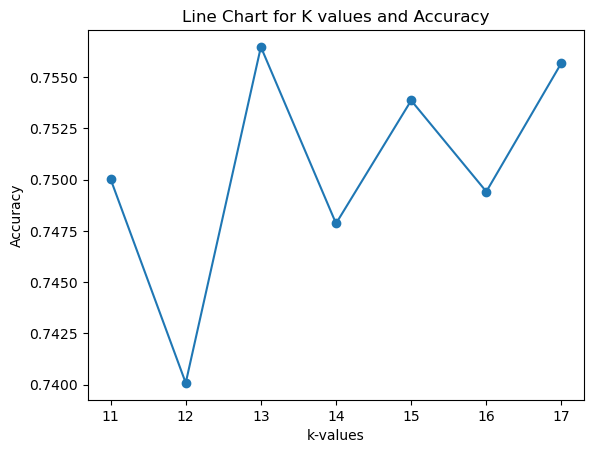

In [33]:
x_values = list(k1.keys())
y_values = list(k1.values())

# Create a line chart
plt.plot(x_values, y_values, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('k-values')
plt.ylabel('Accuracy')
plt.title('Line Chart for K values and Accuracy')

# Show the chart
plt.show()

# Testing

In [39]:
test_data = pd.read_csv('new_test.csv', header = None)

In [40]:
test_data[0] = test_data[0].apply(preprocess_text)

In [41]:
X_test = count_vect.transform(test_data[0])

In [42]:
X_test_tf = tf_transformer.transform(X_test)

In [43]:
X_test = X_test_tf.toarray()
X_test = X_test[:,selected_feature_indices]

In [44]:
knn_classifier = KNN(k=17)
knn_classifier.fit_data(X_train, Y_train)
predictions = knn_classifier.predict_data(X_test)
print(len(predictions))
file_name = "format.txt"


with open(file_name, 'w') as file:
    for prediction in predictions:
        file.write(str(prediction) + '\n')


/var/folders/02/5p20n53n5m93n_nfjv_hj42w0000gn/T/ipykernel_89954/221328879.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity = dot_product / (norm_x * norm_y)


18000
